# Task 3 :- Decision Tree classifier — Bank Marketing

Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. Use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.

In [29]:
# imports & settings

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [30]:
# load data

csv_path = r"d:\Prodigy Infotech Data Science Intership\Task 3\bank\bank-full.csv"
df = pd.read_csv(csv_path, sep=';')
print("shape:", df.shape)
display(df.head())

shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [31]:
# quick EDA

print(df.info())
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=True))
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None

Target distribution:
no     0.883015
yes    0.116985
Name: y, dtype: float64

Missing values 

In [32]:
# prepare features/target

df = df.copy()
df['y'] = df['y'].map({'no':0, 'yes':1})
target = 'y'

categorical_features = ['job','marital','education','default','housing','loan','contact','month','poutcome']
numeric_features = ['age','balance','day','duration','campaign','pdays','previous']

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

X = df[categorical_features + numeric_features]
y = df[target]

Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [33]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (36168, 16) (9043, 16)


In [34]:
# preprocessing + pipeline (handles sklearn version differences)

# OneHotEncoder: prefer sparse_output for newer sklearn; fallback to sparse for older versions

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([('ohe', ohe)])
num_pipe = Pipeline([('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_features),
    ('num', num_pipe, numeric_features)
], remainder='drop')

clf = Pipeline([
    ('pre', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [35]:
# hyperparameter search (including class_weight)

param_grid = {
    'dt__max_depth': [6, 8, 10, None],
    'dt__min_samples_leaf': [1, 5, 10],
    'dt__criterion': ['gini', 'entropy'],
    'dt__class_weight': [None, 'balanced']
}

gs = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)

best_model = gs.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 10}
Best CV ROC AUC: 0.895017588694196


Test accuracy: 0.8970474400088466
Test ROC AUC: 0.8922703604229574

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7985
           1       0.59      0.39      0.47      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.68      0.71      9043
weighted avg       0.88      0.90      0.89      9043



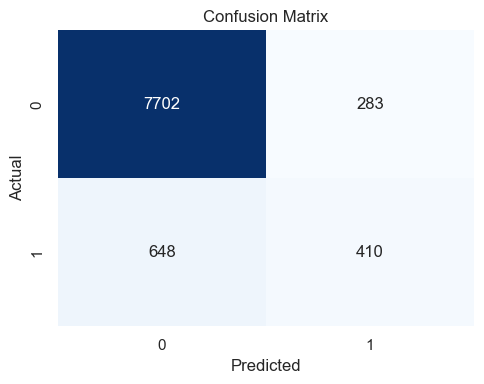

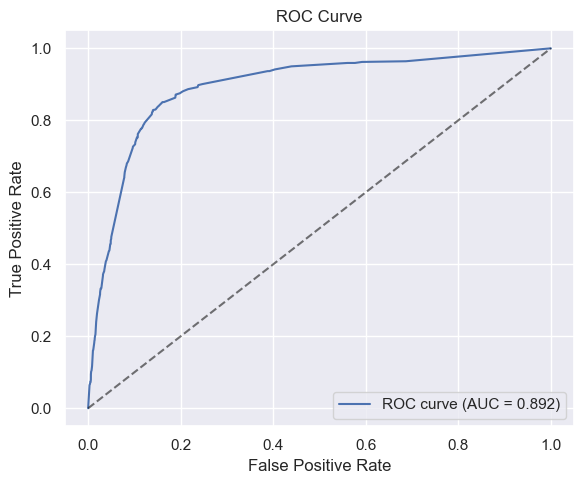

In [36]:
# evaluation: accuracy, ROC AUC, classification report, confusion matrix heatmap, ROC curve

y_pred = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # DecisionTree has predict_proba; fallback if pipeline changes
    y_proba = best_model.decision_function(X_test)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
print("Test accuracy:", acc)
print("Test ROC AUC:", roc)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix heatmap

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ensure predictions/probs exist
try:
    y_pred
except NameError:
    y_pred = best_model.predict(X_test)

try:
    y_proba
except NameError:
    try:
        y_proba = best_model.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

# compute metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

# clean report
print("=== Test set summary ===")
print(f"Samples (test): {len(y_test)}")
print(f"Positives (test): {int(y_test.sum())}")
print(f"Accuracy      : {acc:.4f}")
print(f"ROC AUC       : {roc:.4f}" if not np.isnan(roc) else "ROC AUC       : N/A")
print(f"Precision (1) : {precision:.4f}")
print(f"Recall (1)    : {recall:.4f}")
print(f"F1-score (1)  : {f1:.4f}")

=== Test set summary ===
Samples (test): 9043
Positives (test): 1058
Accuracy      : 0.8970
ROC AUC       : 0.8923
Precision (1) : 0.5916
Recall (1)    : 0.3875
F1-score (1)  : 0.4683


duration            0.425790
poutcome_success    0.179837
contact_unknown     0.068566
day                 0.046113
housing_yes         0.037612
age                 0.025871
pdays               0.020830
month_jul           0.018752
balance             0.017944
month_oct           0.016020
previous            0.015316
month_aug           0.015131
month_feb           0.012816
month_mar           0.012761
month_nov           0.012467
campaign            0.012177
month_jun           0.011143
month_jan           0.008278
month_may           0.007758
month_apr           0.007039
dtype: float64

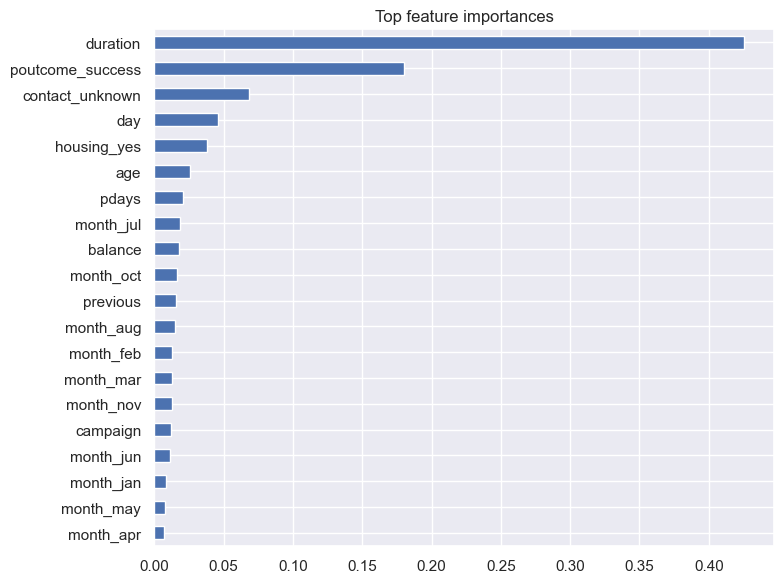

In [38]:
# feature names and importances

# retrieve one-hot feature names robustly

try:
    cat_feat_names = best_model.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_features)
except Exception:
    # older sklearn fallback
    cat_feat_names = best_model.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'].get_feature_names(categorical_features)

num_feat_names = numeric_features
feature_names = list(cat_feat_names) + list(num_feat_names)

importances = best_model.named_steps['dt'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
display(feat_imp.head(20))

plt.figure(figsize=(8,6))
feat_imp.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top feature importances")
plt.tight_layout()
plt.show()

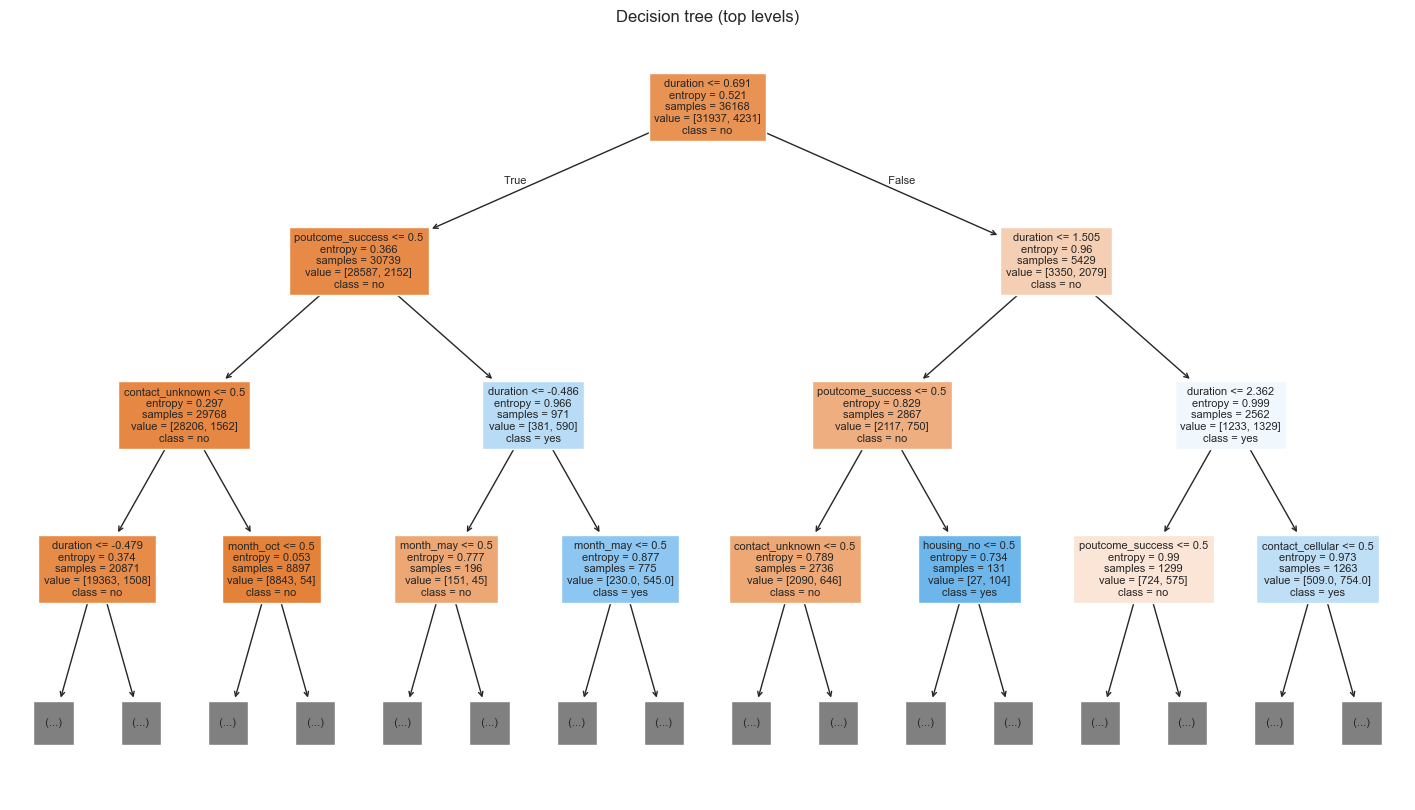

Saved DOT to: d:\Prodigy Infotech Data Science Intership\Task 3\bank_tree.dot
graphviz render not available — DOT saved. To render manually (Windows):
dot -Tpdf "d:\Prodigy Infotech Data Science Intership\Task 3\bank_tree.dot" -o "d:\Prodigy Infotech Data Science Intership\Task 3\bank_tree.pdf"
Exception: No module named 'graphviz'


In [39]:
# visualize tree (plot_tree) and export to DOT/PDF via graphviz if available

plt.figure(figsize=(18,10))
plot_tree(best_model.named_steps['dt'], feature_names=feature_names, class_names=['no','yes'], filled=True, max_depth=3, fontsize=8)
plt.title("Decision tree (top levels)")
plt.show()

dot_data = export_graphviz(
    best_model.named_steps['dt'],
    out_file=None,
    feature_names=feature_names,
    class_names=['no','yes'],
    filled=True,
    rounded=True,
    special_characters=True
)

dot_path = r"d:\Prodigy Infotech Data Science Intership\Task 3\bank_tree.dot"
with open(dot_path, "w", encoding="utf-8") as f:
    f.write(dot_data)
print("Saved DOT to:", dot_path)

# try rendering PDF via python-graphviz if installed

try:
    import graphviz
    g = graphviz.Source(dot_data)
    out_pdf_noext = r"d:\Prodigy Infotech Data Science Intership\Task 3\bank_tree"
    g.render(filename=out_pdf_noext, format='pdf', cleanup=True)
    print("Graphviz PDF saved to:", out_pdf_noext + ".pdf")
except Exception as e:
    print("graphviz render not available — DOT saved. To render manually (Windows):")
    print(f'dot -Tpdf "{dot_path}" -o "{dot_path.replace(".dot", ".pdf")}"')
    print("Exception:", str(e))

In [40]:
# save pipeline

out_path = r"d:\Prodigy Infotech Data Science Intership\Task 3\bank_decision_tree_joblib.pkl"
joblib.dump(best_model, out_path)
print("Saved model to:", out_path)

Saved model to: d:\Prodigy Infotech Data Science Intership\Task 3\bank_decision_tree_joblib.pkl


# Decision Tree classifier (Bank Marketing)

# Summary

Objective:
predict subscription (y) from the UCI Bank Marketing dataset (bank-full.csv).

Data: 
loaded from d:\Prodigy Infotech Data Science Intership\Task 3\bank\bank-full.csv; target y mapped to 0/1.

Features: 
categorical = job, marital, education, default, housing, loan, contact, month, poutcome; numeric = age, balance, day, duration, campaign, pdays, previous.

Split: 
stratified train/test (test_size=0.2, random_state=42).

Preprocessing: 
OneHotEncoder(handle_unknown='ignore') for categoricals (sparse_output fallback handled); StandardScaler for numerics (kept although trees do not require scaling).

Model & tuning: 
DecisionTreeClassifier inside a Pipeline. GridSearchCV (cv=5) over max_depth, min_samples_leaf, criterion, class_weight (None, 'balanced') using ROC AUC as scoring.

Evaluation: 
test accuracy, ROC AUC, classification report, confusion matrix heatmap, ROC curve. Clean summary cell prints main metrics (accuracy, ROC AUC, precision, recall, F1).

Interpretability: 
feature importances (top features) and plot_tree (max_depth limited for readability).

Export & save: 
tree exported to bank_tree.dot (and attempt to render PDF via python-graphviz); final pipeline saved to bank_decision_tree_joblib.pkl.

Key outputs to check in notebook

gs.best_params_ and gs.best_score_ (CV ROC AUC)
Printed Test accuracy, Test ROC AUC, classification report
Confusion matrix heatmap and ROC plot
bank_tree.dot (and bank_tree.pdf if rendered)
bank_decision_tree_joblib.pkl

Recommendations / next steps

Consider removing or testing 'duration' if it leaks target information.
For imbalanced positives: use class_weight='balanced' (already included) or resampling (SMOTE) and evaluate precision/recall or PR AUC.
For more robust tuning use nested CV or repeated CV.
For clearer interpretability restrict max_depth or use SHAP for per-sample explanations.
If graphviz PDF fails: install Graphviz on Windows (choco install graphviz or download) and pip install graphviz; render with dot -Tpdf bank_tree.dot -o bank_tree.pdf.

Place to look in notebook

Hyperparameter search cell: shows grid and best params.
Evaluation cell + reporting cell: main test metrics.
Feature importances / visualization cells: interpretability outputs.
Save/export cells: file locations.